# Galaxy Merger Simulation of Two Disk Galaxies
\
This program shows the user how to set up and run a simulation between two disk galaxies, and how to complete a preliminary analysis of the results. The disk galaxy models were generated using the Agama package (Vasiliev, 2018), and are in quasi-equilibrium when simulated in isolation. Due to the algorithm scaling as O(N$^2$), many of the important components found in spiral galaxies such as gas, dark matter, central black hole, and bulge were omitted, which are integral in keeping the model in equilibrium. This program simulates the interaction between a larger galaxy and a smaller satellite galaxy in a violent collision event.

N-body simulations work by calculating the motion of each particle through time and space based on the mutual gravitational attraction from all the other particles in the simulation. Thus, similarly to chaotic systems and other numerical integration problems, N-body simulations are heavily dependent on the initial conditions of the simulation. As such, most of the work in running simulations is coming up with a suitable set of initial conditions.
***
Please ensure all the appropriate files are downloaded and are in the same directory as this notebook! All the functions used in this notebook are available in the code repository of this project and can be imported for convenience. In this notebook the functions are explicitly defined for transparency.
***
## Table of Contents:
### Steps in running a simulation:
- load initial conditions and create copies for the host and satellite galaxy
- scale the positions, velocities, and masses of the host and satellite galaxy relative to each other; e.i. make the host galaxy 2x more massive
- add disk inclination if desired
- set the galaxies on a collision course
- merge the initial conditions into 3 contiguous NumPy arrays
- run the simulation and analyze the results!
### Analysis and Animating

In [75]:
# import required libraries for mathematical computations and data visualizations
import numpy as np
from numba import njit
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.animation as animation

## Loading initial conditions:
To save computational time, the initial conditions of the spiral galaxy have been precomputed and can be read into Python as a .txt file. Initial conditions for N-body simulations require initial positions, velocities, and masses of each particle in the simulation. For clarity, we will store each parameter in a separate array. For N particles, the position and velocity arrays should have dimensions of N x 3 (this simulation is in 3 dimensions) while masses N x 1. However, the initial conditions provided are stored in an N x 7 array $(x, y, z, v_x, v_y, v_z, m)$ and therefore need to be reshaped. We will write a function to do this efficiently.

In [2]:
def load_phase(initial_phase):
    '''load initial conditions and separate into position, velocity, and mass arrays
    --------------------------------------------------------------------------------------
    initial_phase [NumPy array]: initial N x 7 array of positions, velocities, and masses
    OUTPUT [NumPy array]: N x 3 position array, N x 3 velocity array, and N x 1 mass array
    '''
    # read initial conditions into Python
    phase_space = np.loadtxt(initial_phase)
    # index the initial N x 7 array into respective arrays and return
    return phase_space[:,0:3], phase_space[:,3:6], phase_space[:,6:7]

A .txt file for a simple disk galaxy with 6000 particles is provided.

In [3]:
# load in initial positions, velocities, and masses for host galaxy
host_pos, host_vel, host_mas = load_phase('model_disk_6000')
# print final host galaxy mass
print('final host disk galaxy mass: {}'.format(np.sum(host_mas)))

final host disk galaxy mass: 2.58050598


## Scaling initial conditions
Now that the initial conditions are loaded into Python, we can scale them to create different galaxy models. For this simulation, a smaller 'satellite' galaxy will merge with a larger, more massive 'host' galaxy. We will write another function that scales the positions, velocities, and masses. In this simulation, the mass ratio between the host galaxy and the satellite galaxy is 2.5 : 1.

In [4]:
def scale_phase(pos, vel, mas, R, M):
    '''scale position, velocity, and mass by scalars R and M
    --------------------------------------------------------------------------
    pos, vel, mas [NumPy array]: initial position, velocity, and mass arrays
    R, M [float]: quantities to scale the positions, velocities, and masses by
    OUTPUT [NumPy array]: scaled position, velocity, and mass arrays
    '''
    G = 1 
    # scale position, velocity, and mass by scalar quantities. the velocities are scaled proportionally to a circular orbit velocity
    pos = pos * R
    vel = vel * np.sqrt(G*M/R)
    mas = mas * M
    return pos, vel, mas

In [5]:
# initiate satellite galaxy 
initial_mass = np.sum(host_mas)
# divide by the total mass to normalize the satellite galaxy mass
sat_pos, sat_vel, sat_mas = scale_phase(host_pos, host_vel, host_mas, 1/initial_mass, 1/initial_mass)
print('final satellite disk galaxy mass: {}'.format(np.sum(sat_mas)))

final satellite disk galaxy mass: 1.0000000000000002


## Adding disk inclination to the galaxy model
We can also rotate the disk about a specified axis using a rotation matrix, which will rotate the disk around the $x, y,$ or $z$ axis. In this example, we will rotate the satellite galaxy around the $y$ axis by 45º.

In [6]:
# rotate perturber galaxy
def rotate_disk(pos, vel, deg, axis):
    '''rotate positions and velocities of galaxy about a specified axis
    -------------------------------------------------------------------------------
    pos, vel [NumPy array]: N x 3 position and velocity arrays
    deg [float]: degrees to rotate by
    axis [string]: set this argument to 'x', 'y', or 'z' to rotate around that axis
    OUTPUT [NumPy array]: rotated position and velocity arrays
    '''
    # convert degrees to radians
    rad = np.deg2rad(deg)
    # define sin and cosine functions
    sin, cos = np.sin, np.cos
    # define x, y, z rotation matrices
    rx = np.array([[1, 0, 0],[0, cos(rad), -sin(rad)], [0, sin(rad), cos(rad)]])
    ry = np.array([[cos(rad), 0, sin(rad)],[0, 1, 0], [-sin(rad), 0, cos(rad)]])
    rz = np.array([[cos(rad), -sin(rad), 0],[sin(rad), cos(rad), 0], [0, 0, 1]])
    # ensure position and velocity arrays are appropriate shapes for dot product
    N = pos.shape[0]
    pos, vel = pos.reshape(N,3), vel.reshape(N,3)
    # rotate around specified axis based on user input
    if axis == 'x' or axis == 'X':
        # dot product of positions and velocities with x rotation matrix
        rotated_pts = pos @ rx
        rotated_vel = vel @ rx
    if axis == 'y' or axis == 'Y':
        # dot product of positions and velocities with y rotation matrix
        rotated_pts = pos @ ry
        rotated_vel = vel @ ry
    if axis == 'z' or axis == 'Z':
        # dot product of positions and velocities with z rotation matrix
            rotated_pts = pos @ rz
            rotated_vel = vel @ rz
    return rotated_pts, rotated_vel

In [7]:
# rotate around y axis by 45º
sat_pos, sat_vel = rotate_disk(sat_pos, sat_vel, 45, 'y')

## Set galaxies on a collision course
Both galaxies are by default located at the origin. Thus, we must move the satellite galaxy far from the host galaxy by adding the coordinates of where we want to place it to its position array. We then add a velocity vector to the velocity array of the satellite galaxy pointing in the direction of the host galaxy to set them on a collision course. This vector must be less than the escape velocity of the satellite galaxy if the two galaxies are to merge. We can calculate the escape velocity easily with the escape_v function. For this simulation, we will place the satellite galaxy 40 units away in the x and y direction from the host galaxy.

In [8]:
def escape_v(x, y, z, M):
    '''calculate the escape velocity of the satellite galaxy
    -----------------------------------------------------------------------------------------------------------------------
    x, y, z [float]: x, y, z position of the center of mass of the satellite galaxy
    M [float]: total mass of host galaxy
    OUTPUT [float]: magnitude of the escape velocity of the satellite galaxy at the specified distance from the host galaxy
    '''
    G = 1
    # find length of vector between origin and 
    r = np.sqrt(x**2 + y**2 + z**2)
    return np.sqrt(2*G*M/r)

In [9]:
# calculate the escape velocity of the satellite galaxy placed at x=40,y=40,z=0
escape_velocity = escape_v(40,40,0, np.sum(host_mas))
print('escape velocity: {}'.format(escape_velocity))

escape velocity: 0.3020507637261026


The magnitude of the escape velocity is ~0.3, which can be divided into $x, y$, and $z$ components. To keep things simple, we will keep the host galaxy at rest and set the satellite galaxy on an elliptical orbit into the host galaxy. We can keep the host galaxy at rest if we assume we are in the frame of reference of the host galaxy.

In [10]:
print('magnitude of satellite galaxy trajectory velocity: ', np.sqrt(0.2**2 + 0.12**2))
# move satellite galaxy to its initial position
sat_pos += [40.0, 40.0, 0.0]
# give the satellite galaxy a velocity in the negative x direction less than the escape velocity to put it on a collision path
# the velocity is negative because, from the satellite galaxy, the host galaxy is in the negative x direction
sat_vel += [-0.2, -0.12, 0.0]
# flip the direction of rotation of the host galaxy for stronger gravitational tidal forces
host_vel = host_vel*-1

magnitude of satellite galaxy trajectory velocity:  0.23323807579381203


## Merge the arrays into master position, velocity, and mass arrays
To ensure Numba works properly, it is advantageous to create contiguous NumPy arrays which store the data in the same physical memory location on your computer for faster computation times. This is done easily in NumPy with the function below.

In [11]:
def merger_init(pos1, vel1, mas1, pos2, vel2, mas2):
    '''merge the position, velocity, and mass arrays of two different galaxies into contiguous position, velocity, and mass arrays
    ------------------------------------------------------------------------------------------------------------------------------
    pos1, vel1, mas1 [NumPy array]: position, velocity, and mass arrays of the first galaxy
    pos2, vel2, mas2 [NumPy array]: position, velocity, and mass arrays of the second galaxy
    OUTPUT [NumPy array]: contiguous position, velocity, and mass arrays containing both galaxies
    '''
    # append the second galaxy to the first
    pos = np.append(pos1, pos2, axis = 0)
    vel = np.append(vel1, vel2, axis = 0)
    mas = np.append(mas1, mas2, axis = 0)
    # create contiguous arrays
    positions = np.ascontiguousarray(pos)
    velocities = np.ascontiguousarray(vel)
    masses = np.ascontiguousarray(mas)

    return positions, velocities, masses

In [12]:
positions, velocities, masses = merger_init(host_pos, host_vel, host_mas, sat_pos, sat_vel, sat_mas)

Printing the shape of the position, velocity, and mass arrays, we can see they are now a combination of both galaxies' initial conditions. Since each galaxy had a particle count of N = 6000, the total particle count is now 12,000.

In [13]:
print('positions shape: ', positions.shape, ', velocities shape: ', velocities.shape, ', masses shape: ', masses.shape, ', total simulation mass: ', np.sum(masses))

positions shape:  (12000, 3) , velocities shape:  (12000, 3) , masses shape:  (12000, 1) , total simulation mass:  3.5805059800000008


## Visualizing the simulation setup
before running an expensive simulation, we should verify visually that everything is as it should be! We can create a function to graph simulation snapshots easily which will also be useful when analyzing the results.

In [14]:
def display(galaxies, scale = 100, savefig = False):
    """display a simulation snapshot using matplotlib
    ----------------------------------------------------------------------------------------
    galaxies [list of arrays]: list of galaxy positions; e.i. galaxies = [host_pos, sat_pos]
    scale [float]: positive and negative axes limits
    savefig [boolean]: set to True to save figure to directory as a png
    OUTPUT [matplotlib figure]: displays the positions of the galaxies in a plot
    """
    # setup figure with 2 subplots, one for plotting x,y projection, the other for plotting x,z projection
    fig, ax = plt.subplots(1,2, figsize = (10,5))
    # format axes, minorticks, fonts, and plot colors
    ax[0].minorticks_on()
    ax[1].minorticks_on()
    ax[0].tick_params(axis = 'both', length = 5, direction = 'in', which = 'both', right = True, top = True)
    ax[1].tick_params(axis = 'both', length = 5, direction = 'in', which = 'both', right = True, top = True)
    plt.rcParams['axes.linewidth'] = 0.6
    plt.rcParams['font.family'] = 'Courier New'
    plt.rcParams['mathtext.default'] = 'regular'
    color = ['darkslateblue', 'purple', 'mediumslateblue', 'orchid', 'black']
    # plot each array in the galaxies list
    for i, g in enumerate(galaxies):
        # plot x,y projection
        ax[0].scatter(g[:,0], g[:,1], s = .11, c = color[i])
        # plot x,z projection
        ax[1].scatter(g[:,0], g[:,2], s = .11, c = color[i])
    # set axes limits
    ax[0].set_xlim(-scale, scale)
    ax[0].set_ylim(-scale, scale)
    ax[1].set_xlim(-scale, scale)
    ax[1].set_ylim(-scale, scale)
    # set axes labels
    ax[0].set_xlabel(r'X', size = 17)
    ax[1].set_xlabel(r'X', size = 17)
    ax[0].set_ylabel(r'Y', size = 17)
    ax[1].set_ylabel(r'Z', size = 17)
    plt.tight_layout()
    # if savefig is True, save figure to directory
    if savefig is not False:
        # promt user to input file name
        file_name = input('please input filename for image (ex: myimage.png): ')
        plt.savefig(file_name, dpi = 300, format = 'png')
    plt.show()

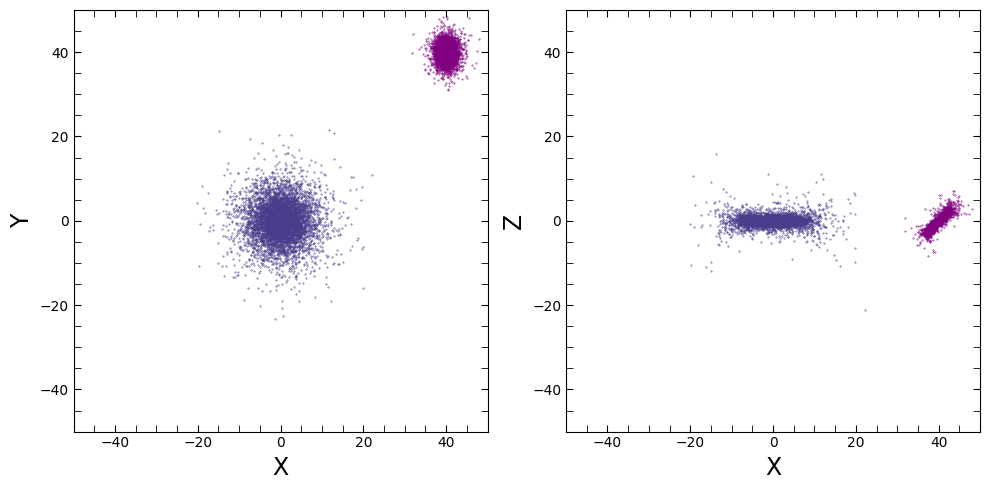

In [15]:
# display the initial simulation setup!
galaxies = [host_pos, sat_pos]
display(galaxies, scale = 50, savefig = False)

# Running the Simulation

## Calculating the Gravitational Acceleration and Potential
To advance each particle, we must calculate the gravitational acceleration acting onto each particle by summing up the contribution from every other particle. This must be done for each particle and is the main bottleneck of the program. The decorator @njit is optional but highly recommended and offers a substantial speed up in calculations.

In [16]:
@njit
def accel_potential(position, mass, Sf, mT):
    '''calculates the gravitational acceleration acting onto each particle as well as the potential of each particle
    ---------------------------------------------------------------------------------------------------------------------------------
    position [NumPy array]: N x 3 array containing the x,y,z position of each particle in the simulation
    mass [NumPy array]: N x 1 array containing the mass of each particle in the simulation
    Sf [float]: softening length, this value is precomputed by the program and doesn't require user input
    mT [NumPy array]: N x N array of every mass-mass product, this value is precomputed by the program and doesn't require user input
    OUTPUT [NumPy array]: N x 3 array containing the gravitational acceleration onto each particle in the simulation
    '''
    G = 1
    # seperate position into x,y,z components
    x = position[:, 0:1]
    y = position[:, 1:2]
    z = position[:, 2:3]
    # calculate particle-particle separations
    delx = x.T - x
    dely = y.T - y
    delz = z.T - z
    delr = np.sqrt(delx**2 + dely**2 + delz**2 + Sf**2)
    
    # calculate acceleration
    g = delr**(-3)
    accelx = G * (delx * g) @ mass
    accely = G * (dely * g) @ mass
    accelz = G * (delz * g) @ mass
    
    # calculate (N x N) particle-particle potential matrix
    potential_N = (G * mT) / delr
    potential_sum = np.sum(potential_N, axis = 0).reshape(position.shape[0], 1)
    # subtract diagonal elements
    potential = potential_sum - np.diag(potential_N).reshape(position.shape[0], 1)
    # divide by mass of each particle
    potential = potential / mass
    
    # return (N x 3) acceleration matrix and (N x 1) potential matrix
    return np.hstack((accelx, accely, accelz)), potential

## N-body Simulation Code
This function is responsible for integrating the motion of each particle and is the main simulation loop. With each piece of the simulation ready, we can run the simulation and then animate the results! This will require substantial CPU operations and RAM to run. If you don't want to run the simulation on your laptop, you can alternatively download the snapshots that I precomputed on my laptop to finish the guide.

In [17]:
def MSGnbody(gal_pos, gal_vel, mass, dt, timesteps, directory, **kwargs):
    '''integrates the motion of N particles under their mutual gravitational attraction through space and time
    --------------------------------------------------------------------------------------------------------------------------
    gal_pos [NumPy array]: N x 3 position array of all particles
    gal_vel [NumPy array]: N x 3 velocity array of all particles
    mass [NumPy array]: N x 1 mass array of all particles
    dt [float]: size of timestep, recommended dt = 0.01
    timesteps [integer]: number of timesteps
    directory [string]: directory path where snapshots are to be saved, including the filename
        best practice is to create a folder within the code directory; the filename should have '{}' before the .npn extension
        example: directory = 'folder/filename{}.npy' 
    **kwargs: mod [integer]: by default, simulation saves every 10 timesteps but can be changed by passing the mod argument
    OUTPUT [.npn file]: the program saves a simulation snapshot of the positions, velocities, and potential every 10 timesteps
    '''  
    ##################
    # simulation setup
    ##################
    # save every 10 timesteps
    mod = 10
    if 'mod' in kwargs:
        mod = kwargs['mod']
    # quantize mod
    mod = int(mod)
    # quantize timesteps
    timesteps = int(timesteps)
    N = gal_pos.shape[0]
    # enforce appropriate array dimensions
    if (gal_pos.shape != (N, 3)) & (gal_vel.shape != (N, 3)) & (mass.shape != (N, 3)):
        print('ERROR: please ensure gal_pos and gal_vel have shapes (N x 3) and mass has shape (N x 1) where N is the total number of particles. gal_pos shape: {} '.format(gal_pos.shape), 'gal_vel shape: {}'.format(gal_vel.shape), 'mass shape: {}'.format(mass.shape), '\n /ᐠ_ ꞈ _ᐟ\ <(fix it...)')
        raise SystemExit
    
    # calculate softening parameter: 
    def get_softening(N):
        '''calculate the softening length as a function of N based on Dehnen (2001)'''
        N5 = N/1e5
        return 0.017 * (N5)**(-0.23)
    soft_param = get_softening(gal_pos.shape[0])
    
    # calculate particle-particle mass products
    mass_product = mass*mass.T
    # calculate initial accelerations 
    gal_accel, gal_potential = accel_potential(gal_pos, mass, soft_param, mass_product)
    
    # save initial conditions
    phase_space0 = np.hstack((gal_pos, gal_vel, gal_potential))
    np.save(directory.format(0), phase_space0)
    np.save('masses.npy', mass)
    
    #################
    # simulation loop
    #################
 
    print('simulation running....  /ᐠ –ꞈ –ᐟ\<[pls be patient]')  
    for n in tqdm(range(1, timesteps+1)):       
        # 1/2 kick
        gal_vel += gal_accel * dt/2.0

        # drift
        gal_pos += gal_vel * dt 
        
        # update accelerations
        gal_accel, gal_potential = accel_potential(gal_pos, mass, soft_param, mass_product)
        
        # update velocities
        gal_vel += gal_accel * dt/2.0
        
        # store phase space from timestep as snapshot saved to directory
        if n % mod == 0:
            phase_space = np.hstack((gal_pos, gal_vel, gal_potential))
            np.save(directory.format(n), phase_space)
    
    return 'simulation complete [yay!!! (ﾐΦ ﻌ Φﾐ)✿ *ᵖᵘʳʳ*]'

# Run the Simulation!
Running this cell will slam multiple CPU cores and take up considerable RAM. This simulation took about 2 hours on my M2 macbook air with 16GB of RAM. The progress bar gives you a good estimate of the remaining computation time, as well as iterations per second. There will be an initial header where the just-in-time Numba compiler has to compile the program into machine code for faster execution. After this, the progress bar should appear.

In [20]:
# run N-body simulation
MSGnbody(positions, velocities, masses, 0.2, 2000, 'guide_snapshots/test_case_snapshots_{}.npy', mod = 10)

simulation running....  /ᐠ –ꞈ –ᐟ\<[pls be patient]


100%|█████████████████████████████████████| 5000/5000 [4:31:36<00:00,  3.26s/it]


'simulation complete [yay!!! (ﾐΦ ﻌ Φﾐ)✿ *ᵖᵘʳʳ*]'

# Viewing the Simulation
We must now load the snapshots back into Python by looping through each timestep and saving it to an array. We will write a function that outputs separate position, velocity, and potential arrays for each galaxy. The array will have 3 indexes, one for timesteps, one for number of particles, and one for number of dimensions ($x, y, z$)

In [16]:
def load_galaxies(directory, timesteps, N, Ngal1):
    '''loops through each simulation snapshot file and loads it into a NumPy array
    ---------------------------------------------------------------------------------------------------------------------
    directory [string]: directory where snapshots are stored on computer ex: 'guide_snapshots/test_case_snapshots_{}.npy'
        ensure that '{}' is in the filename as a placeholder for the timestep number
    timesteps [integer]: number of timesteps
    N [integer]: total number of particles
    Ngal1 [integer]: total number of particles in galaxy one
    OUTPUT [NumPy array]: position, velocity, and potential arrays for each galaxy with shapes (timesteps x N x 3)
    '''
    mod = 10
    # number of timesteps counting timestep 0
    Ntimesteps = int((timesteps + 1)/mod) + 1
    N, Ngal1 = int(N), int(Ngal1)
    # number of particles in second galaxy
    Ngal2 = N - Ngal1
    # number of position/velocity dimensions
    Ncoord = 3
    # create arrays for position, velocity, and potential
    POS_gal1, VEL_gal1 = np.zeros(shape = (Ntimesteps, Ngal1, Ncoord)), np.zeros(shape = (Ntimesteps, Ngal1, Ncoord))
    POT_gal1 = np.zeros(shape = (Ntimesteps, Ngal1, 1))
    POS_gal2, VEL_gal2 = np.zeros(shape = (Ntimesteps, Ngal2, Ncoord)), np.zeros(shape = (Ntimesteps, Ngal2, Ncoord))
    POT_gal2 = np.zeros(shape = (Ntimesteps, Ngal2, Ncoord))
    # function for reading in data
    def load_data(directory, i):
        '''returns position, velocity, and potential at given timestep'''
        data = np.load(directory.format(i))
        return data[:,0:3], data[:,3:6], data[:,6:7]
    for i in tqdm(range(0, Ntimesteps, 1)):
        # load data from timestep
        pos, vel, pot = load_data(directory, i*mod)
        # seperate data into seperate galaxies
        pos_g1, vel_g1, pot_g1 = pos[0:Ngal1], vel[0:Ngal1], pot[0:Ngal1]
        pos_g2, vel_g2, pot_g2 = pos[Ngal1:N], vel[Ngal1:N], pot[Ngal1:N]
        # save data into array
        POS_gal1[i,:,:], POS_gal2[i,:,:] = pos_g1, pos_g2
        VEL_gal1[i,:,:], VEL_gal2[i,:,:] = vel_g1, vel_g2
        POT_gal1[i,:,:], POT_gal2[i,:,:] = pot_g1, pot_g2
    return POS_gal1, VEL_gal1, POT_gal1, POS_gal2, VEL_gal2, POT_gal2

In [17]:
NposHost, NvelHost, NpotHost, NposSat, NvelSat, NpotSat = load_galaxies('guide_snapshots/test_case_snapshots_{}.npy', 2000, 12000, 6000)

100%|████████████████████████████████████████| 201/201 [00:00<00:00, 715.81it/s]


Now if we want to check a specific timestep, we can easily do that with the display function. Lets look at timesteps 50, 75, 90, 110, 120, and 200!

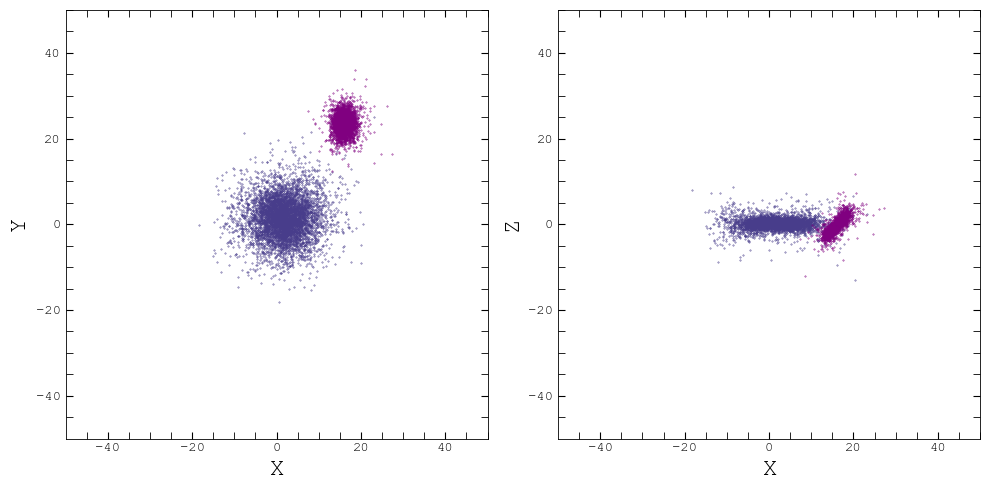

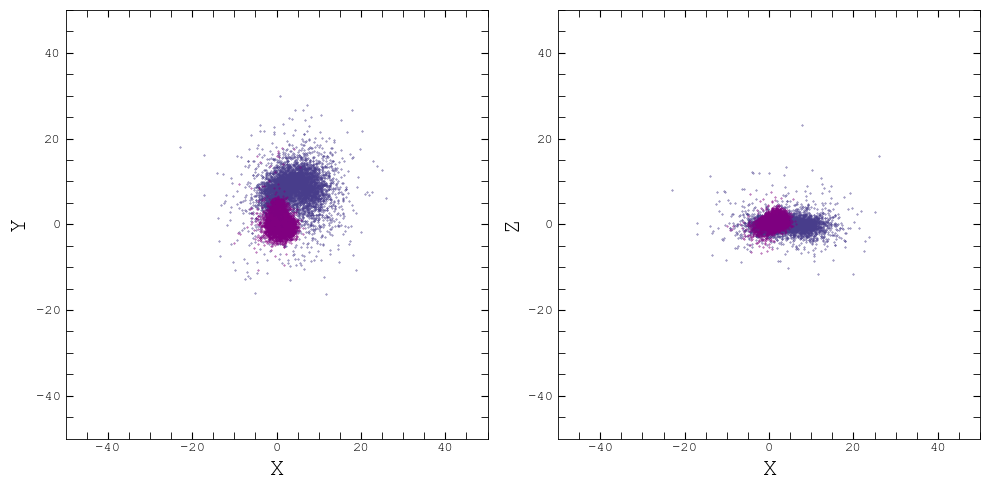

In [25]:
display([NposHost[50,:,:], NposSat[50,:,:]], scale = 50)
display([NposHost[75,:,:], NposSat[75,:,:]], scale = 50)

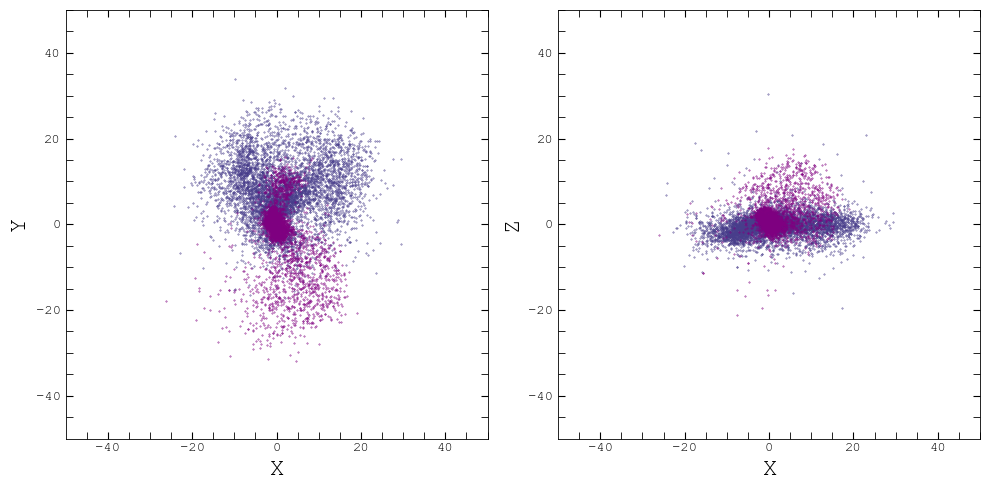

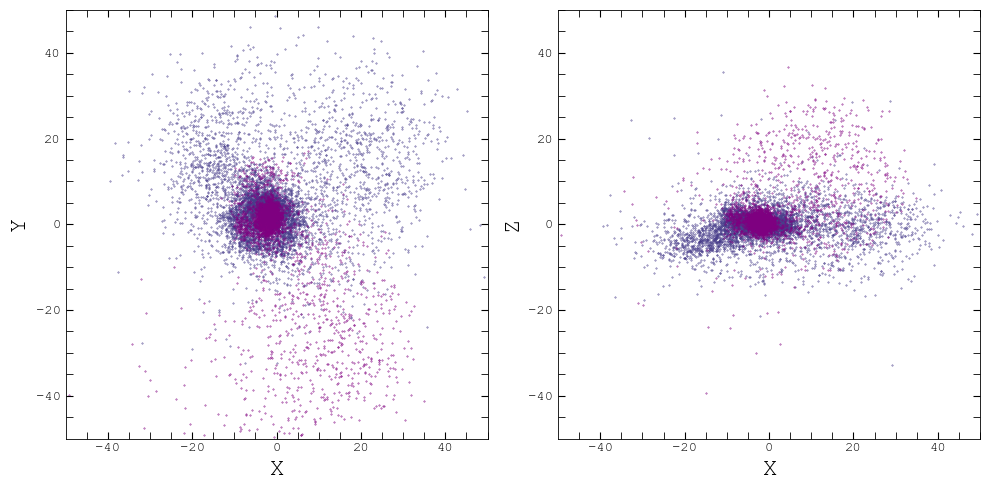

In [26]:
display([NposHost[90,:,:], NposSat[90,:,:]], scale = 50)
display([NposHost[110,:,:], NposSat[110,:,:]], scale = 50)

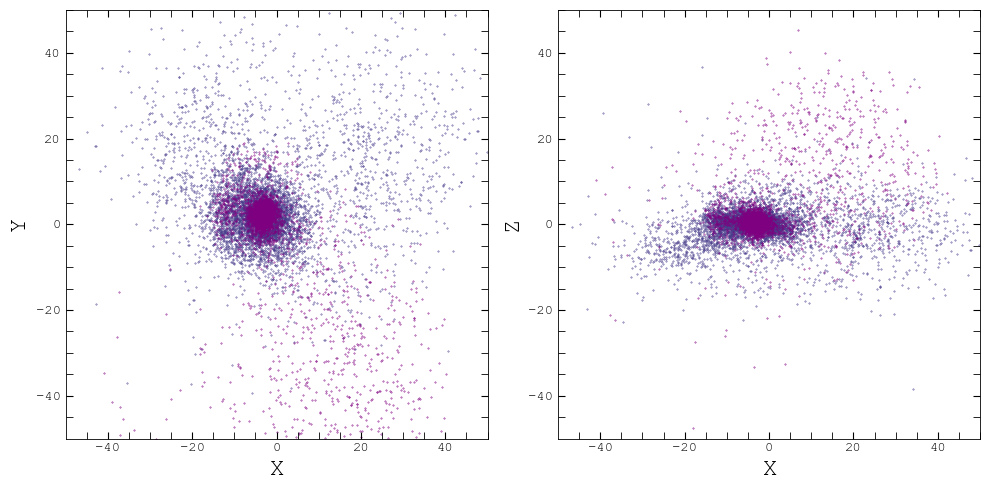

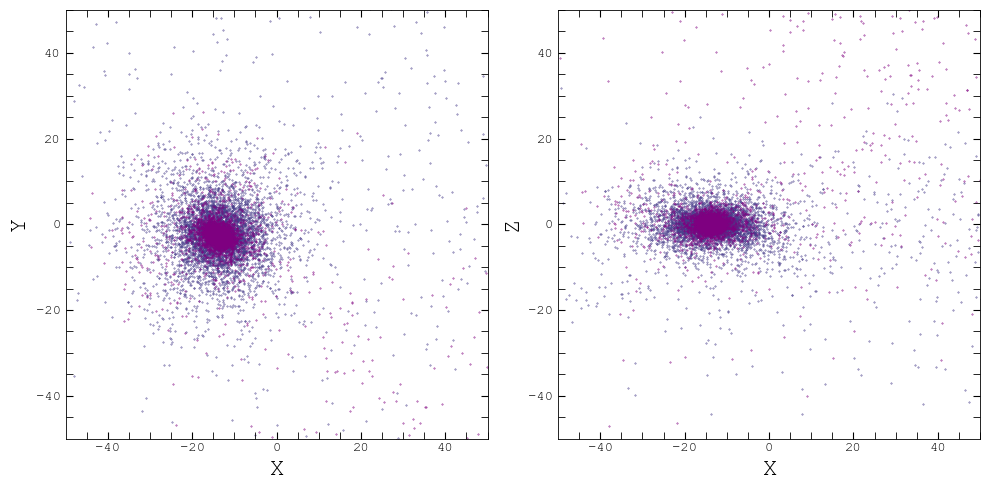

In [27]:
display([NposHost[120,:,:], NposSat[120,:,:]], scale = 50)
display([NposHost[200,:,:], NposSat[200,:,:]], scale = 50)

## Graphing the Energies
We can see how the Energy of each galaxy changes throughout the merger by calculating the N(E) distribution. This function gives you the number of particles at a given Energy level.

In [78]:
def get_Energy(vel, pot):
    '''computes the relative Energy, epsilon, based on the velocity and potential'''
    epsilon = pot - (1/2)*(vel[:,0:1]**2 + vel[:,1:2]**2 + vel[:,2:3]**2)
    return epsilon

In [79]:
# compute energy of each galaxy for each timestep
Energy_host = get_Energy(NvelHost, NpotHost)
Energy_sat = get_Energy(NvelSat, NpotSat)

In [83]:
def plot_Ne(Energies, labels, savefig = False, bin_m = -3,  bin_M = .1):
    # setup figure
    plt.figure(figsize = (5,5))
    plt.rcParams['font.family'] = 'Courier New'
    plt.minorticks_on()
    plt.tick_params(axis = 'both', length = 5, direction = 'in', which = 'both', right = True, top = True)
    plt.rcParams['axes.linewidth'] = 0.6
    ls = ['solid', '--', 'dotted', 'dashdot']
    color = ['k', 'darkslateblue', 'mediumslateblue', 'purple']
    
    # normalized simulated data
    for i, g in enumerate(Energies):
        hist, edges = np.histogram(g, bins = np.logspace(bin_m, bin_M, 65))
        center = (edges[1:] + edges[:-1])/2
        plt.step(center, hist/np.max(hist), color = color[i], lw = .6, ls = ls[i], label = labels[i])
    
    plt.xlabel('E', size = 13)
    plt.ylabel('N(E)', size = 13)
    plt.yscale('log')
    plt.xscale('log')
    plt.legend(loc = 'upper left')
    plt.tight_layout()
    if savefig is True:
        file_name = input('please input filename for image (ex: myimage.png): ')
        plt.savefig(file_name, dpi = 300, format = 'png')
    plt.show()

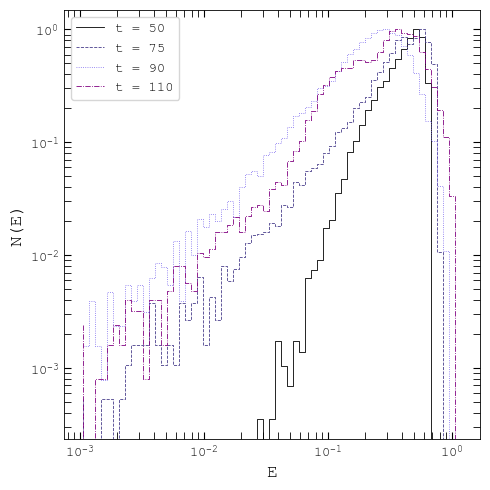

In [84]:
labels = ['t = 50', 't = 75', 't = 90', 't = 110']
plot_Ne([Energy_host[50,:,:], Energy_host[75,:,:], Energy_host[90,:,:], Energy_host[110,:,:]], labels)

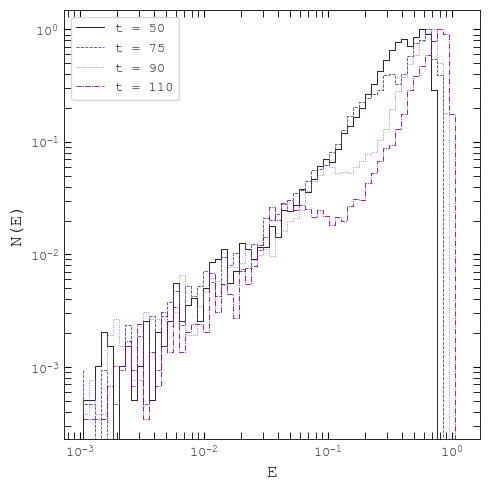

In [85]:
plot_Ne([Energy_sat[50,:,:], Energy_sat[75,:,:], Energy_sat[90,:,:], Energy_sat[110,:,:]], labels)